In [1]:
import pandas as pd 
import numpy as np 
from sklearn.svm import NuSVR, NuSVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
import pingouin as pg
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import random
import pwlf
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import os


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
with open(r"../../DerivedData/cohorts_subjects_list.pickle", "rb") as input_file:
        cohorts = pickle.load(input_file)
        
outcomes = ['Cognitive Score','Language Score','Motor Score']
n_folds = 46
it_num = 1000

### Categorical prediction - prematurity status 

Possible inputs:
- GA birth 
- PMA scan 
- FA 
- corrected FA 
- GA birth + PMA scan 
- GA birth + PMA scan + FA 
- GA birth + PMA scan + corrected FA
- Median FA regions (52) 
- Median FA regions (52) (corrected)


In [3]:
### ages
df = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

### global FA
glob = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

metrics = ['FA', 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in glob.iterrows():
        glob.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
df = pd.merge(df, glob[['subject_id', 'FA']], on=['subject_id'])  

### median FA regions 
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = df.copy()
new_df = pd.merge(new_df, diff[FA_cols], on=['subject_id'])

In [4]:
## create categories for Prematurity prediction 

new_df['group'] = 'FT'
new_df.loc[new_df['GA_birth'] < 37, 'group'] = 'PT'

new_df['group_cat'] = 0
new_df.loc[new_df['GA_birth'] < 37, 'group_cat'] = 1

In [5]:
new_df

,subject_id,session_id,template,PMA_scan,GA_birth,Sex,Weight_birth,Radiology_score,ethnicity_mother,ethnicity_father,...,right_103_FA,right_105_FA,right_107_FA,right_109_FA,right_111_FA,right_113_FA,right_117_FA,right_121_FA,group,group_cat
0,CC00063AN06,15102,36.0,35.71,35.142857,female,1.950,1.0,White,White,...,0.058259,0.088164,0.076715,0.086166,0.065245,0.076998,0.089930,0.075798,PT,1
1,CC00063BN06,15104,36.0,35.71,35.142857,female,2.100,1.0,White,White,...,0.051942,0.071580,0.067764,0.074317,0.063285,0.071518,0.067187,0.066107,PT,1
2,CC00065XX08,18600,39.0,40.71,40.428571,male,3.400,2.0,White,White,...,0.070960,0.079381,0.071109,0.069239,0.070244,0.068954,0.079460,0.082748,FT,0
3,CC00067XX10,20200,39.0,40.14,40.000000,male,3.125,1.0,Asian/Asian British,Asian/Asian British,...,0.070331,0.058335,0.057038,0.053973,0.052619,0.052928,0.098984,0.084126,FT,0
4,CC00068XX11,20701,39.0,40.71,40.428571,female,3.580,1.0,White,White,...,0.070577,0.075920,0.071962,0.059348,0.077020,0.064880,0.071142,0.087423,FT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,CC01192XX14,147330,39.0,43.57,40.285714,male,3.940,1.0,White,White,...,0.066565,0.071107,0.067779,0.076687,0.065743,0.069686,0.095059,0.079283,FT,0
353,CC01198XX20,140930,39.0,42.00,41.571429,female,3.400,1.0,White,White,...,0.096649,0.066844,0.064584,0.065533,0.071771,0.064150,0.093717,0.080333,FT,0
354,CC01199XX21,141130,39.0,40.14,39.857143,male,3.135,1.0,Asian/Asian British,Asian/Asian British,...,0.073310,0.073541,0.070169,0.062530,0.066990,0.066108,0.097840,0.086955,FT,0
355,CC01206XX10,143530,39.0,43.86,41.857143,male,4.000,2.0,White,White,...,0.064520,0.067414,0.069828,0.071216,0.068149,0.071478,0.084256,0.078080,FT,0


In [10]:
parcels = 128
path_to_random = '/neurospin/grip/external_databases/dHCP_CR_JD_2018/Projects/eLife_replication/DerivedData/extracted_metrics/'
random_df = pd.read_csv(os.path.join(path_to_random, 'random_parcellation_{}_diffusion_metric_median.csv'.format(parcels)), index_col=0)

In [17]:
sub_df = new_df[new_df.subject_id.isin(cohorts['D'])].copy()

In [18]:
random_df = pd.merge(random_df, sub_df[['subject_id', 'group_cat']], on='subject_id', how='inner')
random_df

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'group_cat_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


,subject_id,session_id,left_0_FA,left_1_FA,left_2_FA,left_3_FA,left_4_FA,left_5_FA,left_6_FA,left_7_FA,...,right_58_MD,right_59_MD,right_60_MD,right_61_MD,right_62_MD,right_63_MD,group_cat_x,group_cat_y,group_cat_x,group_cat_y
0,CC00063BN06,15104,0.075020,0.070572,0.071701,0.075457,0.077495,0.055550,0.077807,0.070269,...,0.001106,0.001246,0.001241,0.001118,0.001079,0.001059,1,1,1,1
1,CC00065XX08,18600,0.073778,0.094588,0.080378,0.072118,0.087222,0.061903,0.080836,0.071099,...,0.000992,0.001108,0.001047,0.001081,0.001035,0.000985,0,0,0,0
2,CC00067XX10,20200,0.062468,0.074874,0.064397,0.065445,0.076039,0.049402,0.074901,0.057764,...,0.000989,0.001153,0.001090,0.001153,0.001092,0.001025,0,0,0,0
3,CC00071XX06,27000,0.075238,0.074568,0.063566,0.070655,0.072433,0.067702,0.073377,0.065623,...,0.000958,0.001132,0.001080,0.001109,0.001079,0.001030,0,0,0,0
4,CC00072XX07,27600,0.087549,0.080078,0.071014,0.082447,0.091288,0.065212,0.087910,0.083622,...,0.001036,0.001167,0.001003,0.001108,0.001089,0.001041,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,CC00915XX16,18530,0.080089,0.076479,0.063982,0.082029,0.086348,0.058960,0.078030,0.071615,...,0.001015,0.001111,0.001062,0.001140,0.001077,0.001021,0,0,0,0
122,CC00928XX21,37430,0.067809,0.081026,0.079184,0.078558,0.078859,0.064276,0.078969,0.074317,...,0.000974,0.001178,0.001097,0.001104,0.001001,0.000986,0,0,0,0
123,CC01086XX15,100430,0.086328,0.077050,0.065350,0.081721,0.083852,0.075920,0.084399,0.084556,...,0.001051,0.001114,0.001117,0.001153,0.001104,0.001029,0,0,0,0
124,CC01111XX06,100031,0.075618,0.073952,0.071094,0.082677,0.097392,0.067355,0.087464,0.082592,...,0.001032,0.001145,0.001084,0.001153,0.001119,0.001013,1,1,1,1


In [13]:
inputs_random = [col for col in random_df.columns if 'FA' in col]
inputs_random

['left_0_FA',
 'left_1_FA',
 'left_2_FA',
 'left_3_FA',
 'left_4_FA',
 'left_5_FA',
 'left_6_FA',
 'left_7_FA',
 'left_8_FA',
 'left_9_FA',
 'left_10_FA',
 'left_11_FA',
 'left_12_FA',
 'left_13_FA',
 'left_14_FA',
 'left_15_FA',
 'left_16_FA',
 'left_17_FA',
 'left_18_FA',
 'left_19_FA',
 'left_20_FA',
 'left_21_FA',
 'left_22_FA',
 'left_23_FA',
 'left_24_FA',
 'left_25_FA',
 'left_26_FA',
 'left_27_FA',
 'left_28_FA',
 'left_29_FA',
 'left_30_FA',
 'left_31_FA',
 'left_32_FA',
 'left_33_FA',
 'left_34_FA',
 'left_35_FA',
 'left_36_FA',
 'left_37_FA',
 'left_38_FA',
 'left_39_FA',
 'left_40_FA',
 'left_41_FA',
 'left_42_FA',
 'left_43_FA',
 'left_44_FA',
 'left_45_FA',
 'left_46_FA',
 'left_47_FA',
 'left_48_FA',
 'left_49_FA',
 'left_50_FA',
 'left_51_FA',
 'left_52_FA',
 'left_53_FA',
 'left_54_FA',
 'left_55_FA',
 'left_56_FA',
 'left_57_FA',
 'left_58_FA',
 'left_59_FA',
 'left_60_FA',
 'left_61_FA',
 'left_62_FA',
 'left_63_FA',
 'right_0_FA',
 'right_1_FA',
 'right_2_FA',
 'rig

## asess the colinearity between regional FA

In [104]:
def corr_sig(test_df=None):
    test_df.dropna(inplace=True)
    
    p_matrix = np.zeros(shape=(test_df.shape[1], test_df.shape[1]))
    
    p_for_cor = []
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:

            p = pg.corr(test_df[col],test_df[col2])['p-val'][0].astype(np.float64)
            p_for_cor.append(p)
            
    _, p_cor = pg.multicomp(p_for_cor, method='FDR_bh')    
    
    i=0
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:
            
            p_matrix[test_df.columns.to_list().index(col),test_df.columns.to_list().index(col2)] = p_cor[i]
            i = i + 1
            
    return p_matrix


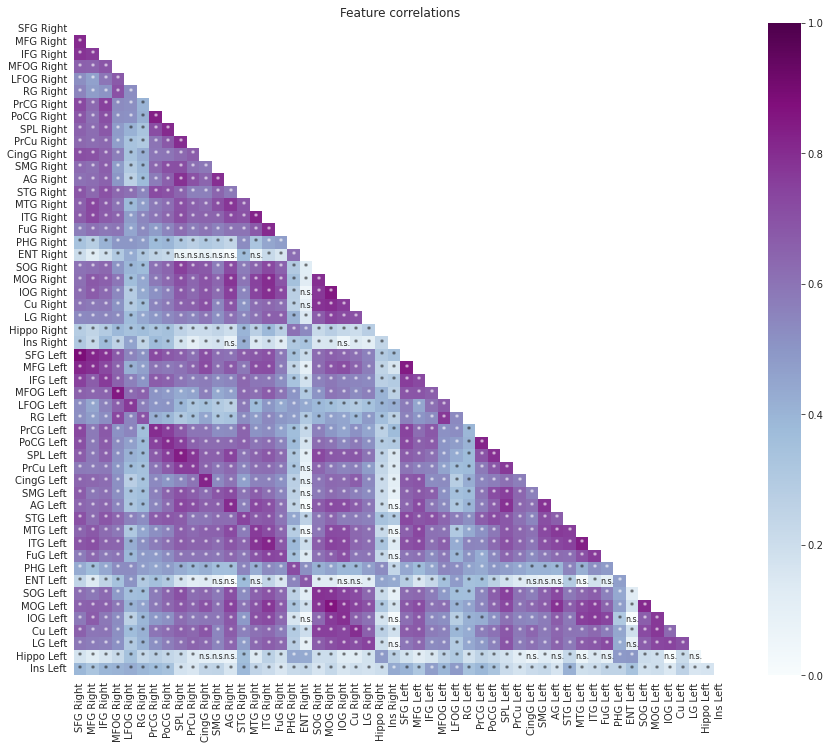

In [106]:
pre_corr = new_df[FA_cols[:-1]].corr()
mask = np.zeros_like(pre_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=new_df[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(pre_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations')
plt.show()
        

In [150]:
## same but after correction for PMA at scan 

df_corrected = new_df[FA_cols[:-1]+['PMA_scan']].copy().dropna()
x0 = np.array([min(df_corrected['PMA_scan']), inflection, max(df_corrected['PMA_scan'])])

for col in df_corrected.columns[:-1]:
    myPWLF = pwlf.PiecewiseLinFit(df_corrected['PMA_scan'].values, df_corrected[col].values)
    myPWLF.fit_with_breaks(x0)
        
    ## correct train 
    yHat_train = myPWLF.predict(df_corrected['PMA_scan'].values)
    res_train = df_corrected[col].values - yHat_train

    df_corrected[col] = res_train

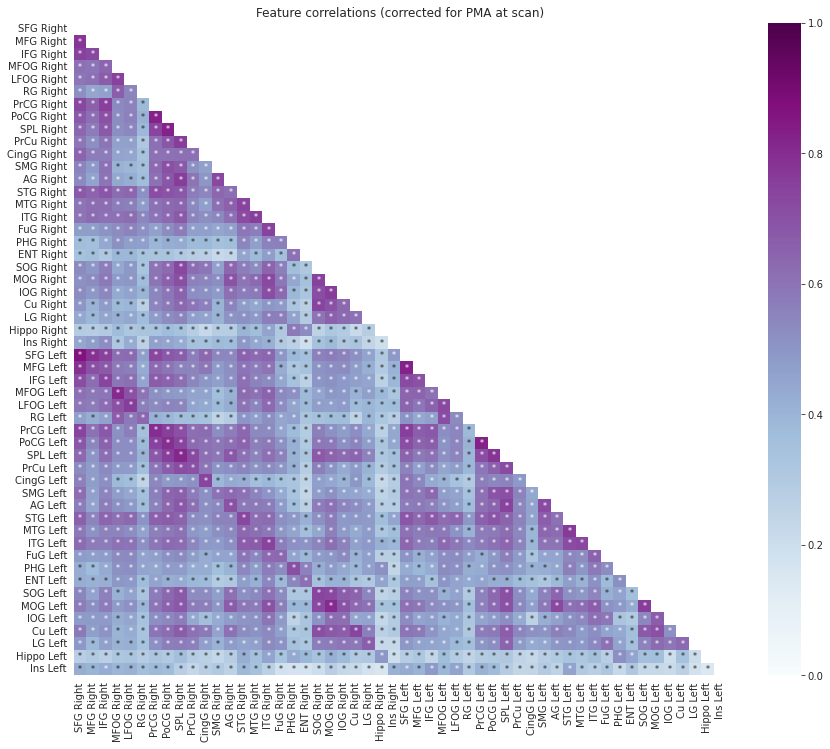

In [151]:
post_corr = df_corrected[FA_cols[:-1]].corr()

mask = np.zeros_like(post_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=df_corrected[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(post_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations (corrected for PMA at scan)')
plt.show()

### Setting up the prematurity status prediction as baseline

In [203]:
def _scaling(X_train, X_test):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

def _impute_median(X_train, X_test):
    
    for col in range(len(X_train[0])):
        
        md = np.nanmedian(X_train[:,col])
        
        X_train[:,col][np.isnan(X_train[:,col])] = md
        X_test[:,col][np.isnan(X_test[:,col])] = md
    
    return X_train, X_test


def get_null_distribution(X,y,n_folds, mode, it=1000, correct_cols=None, PMA_scan=None, inflection=36, scale=True):

    if mode == 'cat':
        dst = []
        for i in range(it):
        
            y_shf = np.random.permutation(y)
        
            auc = train_test_evaluate(X, y_shf, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)
            dst.append(auc)
        return dst
    
    elif mode == 'cont':
        
        rho_dst = []
        p_val = []
        
        for i in range(it):
        
            y_shf = np.random.permutation(y)
        
            rho, p = train_test_evaluate(X, y_shf, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)
            rho_dst.append(rho)
            p_val.append(p)
        
        return rho_dst, p_val
    
def run_model(X,y, n_folds, mode, correct_cols=None, PMA_scan=None, inflection=36, scale=True):

    if mode == 'cat':
        auc = train_test_evaluate(X, y, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)

        return auc
    
    elif mode == 'cont':

        rho, p = train_test_evaluate(X, y_shf, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)

        return rho, p
        
        
def pre_process(X_train, X_test, scale=True, correct_cols=None, PMA_scan=None, inflection=36, train_index=None, test_index=None):
    # impute median
    X_train, X_test = _impute_median(X_train=X_train, X_test=X_test)
    
    # correct age
    X_train, X_test = _correct_age(X_train=X_train, X_test=X_test, 
                                   correct_cols=correct_cols, PMA_scan=PMA_scan, 
                                   train_index=train_index, test_index=test_index, 
                                   inflection=inflection)
    
    # scaling
    if scale==True:
        X_train, X_test = _scaling(X_train= X_train, X_test = X_test)
    
    return X_train, X_test

def _correct_age(X_train, X_test, correct_cols, PMA_scan, train_index, test_index, inflection=36):
    
    PMA_train, PMA_test = PMA_scan[train_index], PMA_scan[test_index]
    x0 = np.array([min(PMA_train), inflection, max(PMA_train)])
    
    if correct_cols != None and len(X_train.shape) == 1:
        #print('correcting 1D input')
        myPWLF = pwlf.PiecewiseLinFit(PMA_train, X_train)
        myPWLF.fit_with_breaks(x0)
        
        ## correct train 
        yHat_train = myPWLF.predict(PMA_train)
        res_train = X_train - yHat_train

        ## correct test 
        yHat_test = myPWLF.predict(PMA_test)
        res_test = X_test - yHat_test

        X_train = res_train
        X_test = res_test
        
    elif correct_cols != None:
        #print('correcting {} input'.format(len(correct_cols)))
        for idx in correct_cols:
        
            ### fit the corrector
            myPWLF = pwlf.PiecewiseLinFit(PMA_train, X_train[:,idx])
            myPWLF.fit_with_breaks(x0)
        
            ## correct train 
            yHat_train = myPWLF.predict(PMA_train)
            res_train = X_train[:,idx] - yHat_train

            ## correct test 
            yHat_test = myPWLF.predict(PMA_test)
            res_test = X_test[:,idx] - yHat_test

            X_train[:,idx] = res_train
            X_test[:,idx] = res_test
    
    return X_train, X_test     
    
   
def train_test_evaluate(X, y, n_folds, mode, correct_cols=None, PMA_scan=None, inflection=36, scale=True):
     
    loo = KFold(n_splits=n_folds)
    
    y_true = []
    y_pred = [] 
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        ### pull to processing function
        X_train, X_test = pre_process(X_train=X_train, X_test=X_test, scale=scale, correct_cols=correct_cols, 
                                     PMA_scan=PMA_scan, train_index=train_index, test_index=test_index, inflection=inflection)
        
        if mode == 'cat':
            
            #clf = NuSVR(C=9, kernel='linear')
            clf = SVC( C=9, kernel='linear')
            #clf = LogisticRegression()
            clf.fit(X_train, y_train)
            y_out = clf.predict(X_test)

            y_out[y_out>0.5]=1
            y_out[y_out<=0.5]=0
    
            for el in range(len(y_test)):
                y_true.append(y_test[el])
                y_pred.append(y_out[el])
                
        if mode == 'cont':
            
            clf = NuSVR(C=9, kernel='linear')
            #clf = SVC( C=9, kernel='linear')
            #clf = LogisticRegression()
            clf.fit(X_train, y_train)
            y_out = clf.predict(X_test)
    
            for el in range(len(y_test)):
                y_true.append(y_test[el])
                y_pred.append(y_out[el])
                
    if mode == 'cat':
        return roc_auc_score(y_true, y_pred)
    
    elif mode == 'cont':
        return pg.corr(y_true, y_pred)['r'][0], pg.corr(y_true, y_pred)['p-val'][0]

def get_cols_for_correction(cols):
    for_corr_idx = []
    train_col = []
    
    for idx, col in enumerate(cols):
        if '_corr' in col:
            for_corr_idx.append(idx)
            train_col.append('_'.join(col.split('_')[:-1]))
        else: 
            train_col.append(col)
    if len(for_corr_idx) == 0:
        for_corr_idx = None
 
    return for_corr_idx, train_col

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_repeated_kfold(X,y,n_folds, mode, it=25, correct_cols=None, PMA_scan=None, inflection=36, scale=True):

    if mode == 'cat':
        dst = []
        for i in range(it):
            
            X,y = unison_shuffled_copies(a=X, b=y)
            auc = train_test_evaluate(X, y, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)
            dst.append(auc)
        return dst
    
    elif mode == 'cont':
        
        rho_dst = []
        p_val = []
        
        for i in range(it):
        
            X,y = unison_shuffled_copies(a=X, b=y)
            rho, p = train_test_evaluate(X, y, n_folds=n_folds, mode=mode, correct_cols=correct_cols, 
                                      PMA_scan=PMA_scan, inflection=inflection, scale=scale)
            rho_dst.append(rho)
            p_val.append(p)
        
        return rho_dst, p_val

In [204]:
### loop over cohorts HERE
sub_df = new_df[new_df.subject_id.isin(cohorts['A'])].copy()

inputs = [['GA_birth'], 
         ['PMA_scan'],
         ['FA'],
         ['FA_corr'],
         ['GA_birth', 'PMA_scan'],
         ['GA_birth', 'PMA_scan', 'FA'],
         ['FA_corr','GA_birth', 'PMA_scan'],
         FA_cols[:-1], 
         [col+'_corr' for col in FA_cols[:-1]]]

o_file = '../../Results/predictions/baseline_predictors_prematurity.txt'
if os.path.exists(o_file):
    os.remove(o_file)
    
with open(o_file, 'a') as the_file:
    the_file.write('inputs,AUC,p-val\n')

for in_cols in inputs:
        print(in_cols)
        for_corr_idx, train_col = get_cols_for_correction(cols=in_cols)    

        print('Correcting: {}'.format(for_corr_idx))
        ### replication
        X = sub_df[train_col].values
        y = sub_df['group_cat'].values

        null = get_null_distribution(X=X,y=y,
                                     n_folds=n_folds, mode='cat', it=1000, 
                                     correct_cols=for_corr_idx, 
                                     PMA_scan=sub_df['PMA_scan'].values, 
                                     inflection=36, scale=True)

        auc = run_model(X=X,y=y,n_folds=n_folds, mode='cat',  
                                     correct_cols=for_corr_idx, 
                                     PMA_scan=sub_df['PMA_scan'].values, 
                                     inflection=36, scale=True)

        p_permuted = np.sum(null>=auc) / len(null)

        print(in_cols)
        print('REPLICATION: {:.3f} (p={})'.format( auc, p_permuted))


        ### implemented shuffle here evaluation here
        reps = get_repeated_kfold(X=X,y=y,
                                     n_folds=n_folds, mode='cat', it=100, 
                                     correct_cols=for_corr_idx, 
                                     PMA_scan=sub_df['PMA_scan'].values, 
                                     inflection=36, scale=True)
        print('Shuffled: mean AUC {:.3f}, sdt {:.4f}'.format(np.mean(reps), np.std(reps)))

        #with open(o_file, 'a') as the_file:
        #    the_file.write('{},{:.3f},p={}\n'.format(in_cols,auc, p_permuted ))

['GA_birth']
Correcting: None
['GA_birth']
REPLICATION: 0.976 (p=0.0)
Shuffled: mean AUC 0.975, sdt 0.0033
['PMA_scan']
Correcting: None
['PMA_scan']
REPLICATION: 0.890 (p=0.0)
Shuffled: mean AUC 0.890, sdt 0.0000
['FA']
Correcting: None
['FA']
REPLICATION: 0.500 (p=1.0)
Shuffled: mean AUC 0.500, sdt 0.0000
['FA_corr']
Correcting: [0]
['FA_corr']
REPLICATION: 0.500 (p=1.0)
Shuffled: mean AUC 0.500, sdt 0.0000
['GA_birth', 'PMA_scan']
Correcting: None
['GA_birth', 'PMA_scan']
REPLICATION: 0.963 (p=0.0)
Shuffled: mean AUC 0.972, sdt 0.0067
['GA_birth', 'PMA_scan', 'FA']
Correcting: None
['GA_birth', 'PMA_scan', 'FA']
REPLICATION: 0.890 (p=0.0)
Shuffled: mean AUC 0.937, sdt 0.0128
['FA_corr', 'GA_birth', 'PMA_scan']
Correcting: [0]
['FA_corr', 'GA_birth', 'PMA_scan']
REPLICATION: 0.890 (p=0.0)


KeyboardInterrupt: 

In [137]:
###### PREMATURITY STATUS - baselines 

inputs = [['GA_birth'], 
         ['PMA_scan'],
         ['FA'],
         ['FA_corr'],
         ['GA_birth', 'PMA_scan'],
         ['GA_birth', 'PMA_scan', 'FA'],
         ['FA_corr','GA_birth', 'PMA_scan'],
         FA_cols[:-1], 
         [col+'_corr' for col in FA_cols[:-1]]]


for in_cols in inputs:
    
    for_corr_idx = []
    train_col = []
    
    for idx, col in enumerate(in_cols):
        if '_corr' in col:
            for_corr_idx.append(idx)
            train_col.append('_'.join(col.split('_')[:-1]))
        else: 
            train_col.append(col)
            

    #print(for_corr_idx)
    #print(train_col)
    
    shf_df = sub_df.copy()
    shf_df = shf_df.sample(frac=1)
    shf_df.reset_index(inplace=True, drop=True)
    
    X = shf_df[train_col].values
    y = shf_df['group_cat'].values
    
    
    AUC = train_test_evaluate_cat(X=X,y=y, 
                                  n_folds=n_folds,
                                  correct_cols = for_corr_idx, 
                                  PMA_scan = sub_df['PMA_scan'].values,
                                  )
    
    
    #print(in_cols, AUC)
    null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100, 
                                    correct_cols=for_corr_idx, 
                                         PMA_scan=shf_df['PMA_scan'].values, inflection=36))
    
    pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
    print('INPUTS: {}'.format(in_cols))
    print('ROC-AUC: {:.3f} (p-val {:.8f})'.format(AUC, pval))  
    
    
    ### getting shuffle repeat     
    rep_AUC = []
    
    shf_df = sub_df.copy()
    for rep in range(25):
        shf_df = shf_df.sample(frac=1)
        shf_df.reset_index(inplace=True, drop=True)

        X = shf_df[train_col].values
        y = shf_df['group_cat'].values
    
        AUC = train_test_evaluate_cat(X=X,y=y, 
                                  n_folds=n_folds,
                                  correct_cols = for_corr_idx, 
                                  PMA_scan = shf_df['PMA_scan'].values,
                                  )
    
        rep_AUC.append(AUC)
    #print(rep_AUC)
    print('mean ROC-AUC: {:.3f} (std {:.8f})'.format(np.mean(rep_AUC), np.std(rep_AUC)))    
    

INPUTS: ['GA_birth']
ROC-AUC: 0.977 (p-val 0.00000000)
mean ROC-AUC: 0.976 (std 0.00227860)
INPUTS: ['PMA_scan']
ROC-AUC: 0.895 (p-val 0.00000000)
mean ROC-AUC: 0.895 (std 0.00000000)
INPUTS: ['FA']
ROC-AUC: 0.500 (p-val 1.00000000)
mean ROC-AUC: 0.500 (std 0.00000000)
INPUTS: ['FA_corr']
ROC-AUC: 0.500 (p-val 1.00000000)
mean ROC-AUC: 0.500 (std 0.00000000)
INPUTS: ['GA_birth', 'PMA_scan']
ROC-AUC: 0.977 (p-val 0.00000000)
mean ROC-AUC: 0.972 (std 0.00986661)
INPUTS: ['GA_birth', 'PMA_scan', 'FA']
ROC-AUC: 0.942 (p-val 0.00000000)
mean ROC-AUC: 0.940 (std 0.00986661)
INPUTS: ['FA_corr', 'GA_birth', 'PMA_scan']
ROC-AUC: 0.953 (p-val 0.00000000)
mean ROC-AUC: 0.938 (std 0.00797508)
INPUTS: ['left_68_FA', 'left_70_FA', 'left_72_FA', 'left_74_FA', 'left_76_FA', 'left_78_FA', 'left_80_FA', 'left_82_FA', 'left_84_FA', 'left_86_FA', 'left_88_FA', 'left_90_FA', 'left_92_FA', 'left_94_FA', 'left_96_FA', 'left_98_FA', 'left_100_FA', 'left_102_FA', 'left_104_FA', 'left_106_FA', 'left_108_FA', 'l

In [156]:
from libsvm import svmutil

In [169]:

svmopt = '-s 4 -t 0 -c 9 -g 10 -p 0.1'
model = svmutil.svm_train(y,X,svmopt)

In [170]:
svmutil.svm_predict(y,X, model)

Mean squared error = nan (regression)
Squared correlation coefficient = nan (regression)


([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,

In [155]:
help(svm_model)

Help on class svm_model in module libsvm.svm:

class svm_model(_ctypes.Structure)
 |  Structure base class
 |  
 |  Method resolution order:
 |      svm_model
 |      _ctypes.Structure
 |      _ctypes._CData
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_SV(self)
 |  
 |  get_labels(self)
 |  
 |  get_nr_class(self)
 |  
 |  get_nr_sv(self)
 |  
 |  get_sv_coef(self)
 |  
 |  get_sv_indices(self)
 |  
 |  get_svm_type(self)
 |  
 |  get_svr_probability(self)
 |  
 |  is_probability_model(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  SV
 |      Structure/Union member
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  free_sv
 |      Structure/Union member
 | 

In [23]:
def _scaling(X_train, X_test):
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

def _impute_median(X_train, X_test):
    
    for col in range(len(X_train[0])):
        
        md = np.nanmedian(X_train[:,col])
        
        X_train[:,col][np.isnan(X_train[:,col])] = md
        X_test[:,col][np.isnan(X_test[:,col])] = md
    
    return X_train, X_test

def get_null_dst_cat(X,y, n_folds, it=1000):
    
    X= X.copy()
    y = y.copy()
    dst = []
    for i in range(it):
        
        random.shuffle(y)
        #new_array = random.sample( array, len(array) )
        auc = train_test_evaluate_cat(X,y, n_folds)
        dst.append(auc)
    return dst


def train_test_evaluate_cat(X,y, n_folds):
    
    loo = KFold(n_splits=n_folds)
    y_true = []
    y_pred = [] 
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # scale
        X_train, X_test = _scaling(X_train= X_train, X_test = X_test)
        X_train, X_test = _impute_median(X_train= X_train, X_test = X_test)

        #clf = NuSVR(C=9, kernel='linear' )
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        y_out = clf.predict(X_test)

        y_out[y_out>0.5]=1
        y_out[y_out<=0.5]=0
    
        for el in range(len(y_test)):
            y_true.append(y_test[el])
            y_pred.append(y_out[el])

    auc = roc_auc_score(y_true, y_pred)
    return auc
    
def get_null_dst_cont(X,y, n_folds, it=1000):
    
    X= X.copy()
    y = y.copy()
    dst = []
    for i in range(it):
        
        random.shuffle(y)
        #new_array = random.sample( array, len(array) )
        
        auc, _ = train_test_evaluate_cont(X,y, n_folds)
        dst.append(auc)
    return dst

def train_test_evaluate_cont(X,y, n_folds):
    
    loo = StratifiedKFold(n_splits=n_folds)
    y_true = []
    y_pred = [] 
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # scale
        X_train, X_test = _scaling(X_train= X_train, X_test = X_test)
        X_train, X_test = _impute_median(X_train= X_train, X_test = X_test)

        #clf = NuSVR(C=9, kernel='linear' )
        clf = LinearRegression()
        clf.fit(X_train, y_train)
        y_out = clf.predict(X_test)
    
        for el in range(len(y_test)):
            y_true.append(y_test[el])
            y_pred.append(y_out[el])

    rho, p_val = pg.corr(y_true, y_pred)['r'][0], pg.corr(y_true, y_pred)['p-val'][0]
    return rho, p_val

In [24]:
###### PREMATURITY STATUS - baselines 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


inputs = [['GA_birth'], 
         ['PMA_scan'],
         ['GA_birth', 'PMA_scan'],
         ['GA_birth', 'PMA_scan', 'FA'],
         ['FA']]

for in_cols in inputs:

    X = sub_df[in_cols].values
    y = sub_df['group_cat'].values
    
    AUC = train_test_evaluate_cat(X=X,y=y, n_folds=n_folds)
    null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
    
    pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
    print('INPUTS: {}'.format(in_cols))
    print('ROC-AUC: {:.3f} (p-val {:.8f})'.format(AUC, pval))        


INPUTS: ['GA_birth']
ROC-AUC: 0.698 (p-val 0.00000000)


KeyboardInterrupt: 

In [265]:
### getting shuffle repeat 
for in_cols in inputs:
    print('INPUTS: {}'.format(in_cols))
    
    rep_AUC = []
    
    for rep in range(25):
        sub_df = sub_df.sample(frac=1)

        X = sub_df[in_cols].values
        y = sub_df['group_cat'].values
    
        AUC = train_test_evaluate_cat(X=X,y=y, n_folds=n_folds)
        #null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
        #pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
        rep_AUC.append(AUC)
    print('ROC-AUC: {:.3f} (std {:.4f})'.format(np.mean(rep_AUC), np.std(rep_AUC)))      

INPUTS: ['GA_birth']
ROC-AUC: 0.609 (std 0.0118)
INPUTS: ['PMA_scan']
ROC-AUC: 0.594 (std 0.0047)
INPUTS: ['GA_birth', 'PMA_scan']
ROC-AUC: 0.678 (std 0.0137)
INPUTS: ['GA_birth', 'PMA_scan', 'FA']
ROC-AUC: 0.676 (std 0.0135)
INPUTS: ['FA']
ROC-AUC: 0.500 (std 0.0000)


In [202]:
###### AGE AT scan
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score


inputs = [['GA_birth'], 
         ['PMA_scan'],
         ['GA_birth', 'PMA_scan'],
         ['GA_birth', 'PMA_scan', 'FA'],
         ['FA']]


for in_cols in inputs:

    X = sub_df[in_cols].values
    y = sub_df['GA_birth'].values

    rho, p_val = train_test_evaluate_cont(X=X,y=y, n_folds=n_folds)
    null_dst = np.array(get_null_dst_cont(X=X,y=y, n_folds=n_folds, it=100))

    pval = len(null_dst[null_dst>=rho])/len(null_dst)
    
    print('INPUTS: {}'.format(in_cols))
    print('RHO: {:.2f} (p={:.4f}) (p permutation {:.8f})'.format(rho,p_val, pval))       

INPUTS: ['GA_birth']
RHO: 1.00 (p=0.0000) (p permutation 0.00000000)
INPUTS: ['PMA_scan']
RHO: 0.85 (p=0.0000) (p permutation 0.00000000)
INPUTS: ['GA_birth', 'PMA_scan']
RHO: 1.00 (p=0.0000) (p permutation 0.00000000)
INPUTS: ['GA_birth', 'PMA_scan', 'FA']
RHO: 1.00 (p=0.0000) (p permutation 0.00000000)
INPUTS: ['FA']
RHO: -0.44 (p=0.0000) (p permutation 0.77000000)


In [268]:
### getting shuffle repeat 
for in_cols in inputs:
    print('INPUTS: {}'.format(in_cols))
    
    rep_RHO = []
    rep_p = []
    
    for rep in range(25):
        sub_df = sub_df.sample(frac=1)

        X = sub_df[in_cols].values
        y = sub_df['PMA_scan'].values
    
        rho, p_val = train_test_evaluate_cont(X=X,y=y, n_folds=n_folds)
        #null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
        #pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
        rep_RHO.append(rho)
        rep_p.append(p_val)
    print('RHO: {:.3f} (std {:.4f})'.format(np.mean(rep_RHO), np.std(rep_RHO))) 
    print('p-val: {:.3f} (std {:.4f})'.format(np.mean(rep_p), np.std(rep_p))) 

INPUTS: ['GA_birth']
RHO: 0.845 (std 0.0019)
p-val: 0.000 (std 0.0000)
INPUTS: ['PMA_scan']
RHO: 1.000 (std 0.0000)
p-val: 0.000 (std 0.0000)
INPUTS: ['GA_birth', 'PMA_scan']
RHO: 1.000 (std 0.0000)
p-val: 0.000 (std 0.0000)
INPUTS: ['GA_birth', 'PMA_scan', 'FA']
RHO: 1.000 (std 0.0000)
p-val: 0.000 (std 0.0000)
INPUTS: ['FA']
RHO: -0.160 (std 0.0254)
p-val: 0.083 (std 0.0422)


### Median FA from segmentation to predict prematurity, ages, etc

In [270]:
diff = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

In [283]:
FA_cols = [col for col in diff.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

new_df = df.copy()

new_df = pd.merge(new_df, diff, on=['subject_id'])

sub_df = new_df[new_df.subject_id.isin(cohorts['D'])]


In [228]:
X = sub_df[FA_cols[:-1]].values
y = sub_df['group_cat'].values

AUC = train_test_evaluate_cat(X=X,y=y, n_folds=n_folds)
null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
    
pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
print('INPUTS: {}'.format(in_cols))
print('ROC-AUC: {:.3f} (p-val {:.8f})'.format(AUC, pval))    

INPUTS: ['FA']
ROC-AUC: 0.595 (p-val 0.00000000)


In [284]:
### getting shuffle repeat 

print('INPUTS: {}'.format(in_cols))
    
rep_AUC = []
    
for rep in range(25):
    sub_df = sub_df.sample(frac=1)

    X = sub_df[FA_cols[:-1]].values
    y = sub_df['group_cat'].values
    
    AUC = train_test_evaluate_cat(X=X,y=y, n_folds=n_folds)
    #null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
    #pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
    rep_AUC.append(AUC)
print('ROC-AUC: {:.3f} (std {:.4f})'.format(np.mean(rep_AUC), np.std(rep_AUC)))     

INPUTS: ['FA']
ROC-AUC: 0.595 (std 0.0000)


In [230]:
###### AGE AT scan

X = sub_df[FA_cols[:-1]].values
y = sub_df['PMA_scan'].values

rho, p_val = train_test_evaluate_cont(X=X,y=y, n_folds=n_folds)
null_dst = np.array(get_null_dst_cont(X=X,y=y, n_folds=n_folds, it=100))

pval = len(null_dst[null_dst>=rho])/len(null_dst)
    
print('INPUTS: {}'.format(in_cols))
print('RHO: {:.2f} (p={:.4f}) (p permutation {:.8f})'.format(rho,p_val, pval))       

INPUTS: ['FA']
RHO: 0.59 (p=0.0000) (p permutation 0.00000000)


In [287]:
### getting shuffle repeat 

rep_RHO = []
rep_p = []
    
for rep in range(25):
    sub_df = sub_df.sample(frac=1)

    X = sub_df[FA_cols[:-1]].values
    y = sub_df['PMA_scan'].values
    
    rho, p_val = train_test_evaluate_cont(X=X,y=y, n_folds=n_folds)
    #null_dst = np.array(get_null_dst_cat(X=X,y=y, n_folds=n_folds, it=100))
    #pval = len(null_dst[null_dst>=AUC])/len(null_dst)
    
    rep_RHO.append(rho)
    rep_p.append(p_val)
print('RHO: {:.3f} (std {:.4f})'.format(np.mean(rep_RHO), np.std(rep_RHO))) 
print('p-val: {:.3f} (std {:.4f})'.format(np.mean(rep_p), np.std(rep_p))) 

RHO: 0.580 (std 0.0107)
p-val: 0.000 (std 0.0000)
